# Cyclic peptides

In [1]:
import pandas as pd
df_all= pd.read_csv('data/CycPeptMPDB/all.csv')
df_train = pd.read_csv('data/CycPeptMPDB/train.csv')
df_test = pd.read_csv('data/CycPeptMPDB/test.csv')

pd.set_option('display.max_colwidth', None)

display(df_all.head()['helm'])

y_train = df_train.score.values
y_test = df_test.score.values
y_all = df_all.score.values

0    PEPTIDE2{[Abu].[Sar].[meL].V.[meL].A.[dA].[meL].[meL].[meV].[Me_Bmt(E)]}$PEPTIDE2,PEPTIDE2,1:R1-11:R2$$$
1                                               PEPTIDE1{[dL].[dL].L.[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
2                                            PEPTIDE1{[dL].[dL].[dL].[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
3                                                     PEPTIDE1{L.L.L.[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
4                                               PEPTIDE1{L.[dL].[dL].[dL].P.Y}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$
Name: helm, dtype: object

## Feature processing

### Fingerprints (fps)

In [2]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def fingerprints_from_smiles(smiles: List, size=2048):
    """
        Create ECFP fingerprints of smiles, with validity check
    """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask


def fingerprints_from_mol(molecule, radius=3, size=2048, hashed=False):
    """
        Create ECFP fingerprint of a molecule
    """
    if hashed:
        fp_bits = AllChem.GetHashedMorganFingerprint(molecule, radius, nBits=size)
    else:
        fp_bits = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=size)
    fp_np = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_bits, fp_np)
    return fp_np.reshape(1, -1)

In [3]:
# train = True
train = False
if train:
    X_all = fingerprints_from_smiles(df_all.smi)[0]
    X_train = fingerprints_from_smiles(df_train.smi)[0]
    X_test = fingerprints_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_all_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_train_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_fps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_fps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_fps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_fps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2048), (7451,), (5960, 2048), (5960,), (1491, 2048), (1491,))

### 2D descriptors

In [4]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List
from rdkit import rdBase, Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def get_2d_descriptor_from_mol(m):
    """
    Calculate 2D descriptors from mol object
    :param m: mol object
    :return: 2D descriptors including MW, LogP, TPSA, HBD, HBA, PHI, numAtom, 
    """
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)

    tpsa = Descriptors.TPSA(mol)  # Topological polar surface area
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)  # Number of hydrogen-bond donors
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)  # Number of hydrogen-bond acceptors
    n_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)  # Number of rotatable bonds
    n_atom = m.GetNumAtoms()  # Number of atoms
    return np.array([mw, logp, tpsa, hbd, hba, n_rb, n_atom])

# get_2d_descriptor_from_mol(mol)


def get_2d_descriptor_from_smiles(smiles: List, size=7):
    """
        Create 2d descriptors of smiles, with validity check
    """
    dps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        dp = get_2d_descriptor_from_mol(mol) if mol else np.zeros(size)
        dps.append(dp)

    dps = np.vstack(dps)
    return dps, valid_mask

In [5]:
# train = True
train = False
if train:
    X_all = get_2d_descriptor_from_smiles(df_all.smi)[0]
    X_train = get_2d_descriptor_from_smiles(df_train.smi)[0]
    X_test = get_2d_descriptor_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_all_2dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_train_2dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_2dps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_2dps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_2dps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_2dps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 7), (7451,), (5960, 7), (5960,), (1491, 7), (1491,))

### BERT features

In [6]:
from dataset.tokenizer import SmilesTokenizer, AATokenizer, BPETokenizer
from model.bert import BERT
from utils.utils import parse_config, load_model
import torch

def load_bert_model(ckpt, config, device='cuda', model_type='smi_bert'):
    if model_type == 'smi_bert':
        tokenizer = SmilesTokenizer(max_len=config.data.max_len)
    elif model_type == 'aa_bert':
        tokenizer = AATokenizer(max_len=config.data.max_len)
    elif config.data.type == 'bpe':
        tokenizer = BPETokenizer(bpe_path=config.data.bpe_path, max_len=config.data.max_len)
    else:
        raise ValueError(f'Invalid model_type: {model_type}')

    model = BERT(tokenizer, **config.model)
    model = load_model(model, ckpt, device)
    model.eval()
    return model, device

def get_bert_embd(encoder, inputs, device='cuda',):
    with torch.no_grad():
        tokens = encoder.tokenize_inputs(inputs).to(device)
        batch_lens = (tokens != encoder.tokenizer.pad_token_id).sum(1)
        embd = encoder.embed(tokens)
        reps = []
        for i, tokens_len in enumerate(batch_lens):
            reps.append(embd[i, 1 : tokens_len - 1].mean(0))
    return torch.stack(reps)

def encode_with_bert(list, model, device='cuda', batch_size=128):
    reps = []
    for i in range(0, len(list), batch_size):
        reps.append(get_bert_embd(model, list[i : i + batch_size], device=device))
    reps = torch.cat(reps).cpu().numpy()
    # logger.info(f"list shape: {list.shape}, reps shape: {reps.shape}")
    return reps

#### SMILES BERT

In [9]:
# train = True
train = False
if train:
    ckpt='results/train_smi_bert_tune/model_13_0.003.pt'  # 90.71	93.88	87.06	0.814	0.905
    config_file='configs/train_smi_bert_tune.yaml'
    config = parse_config(config_file)
    model, device = load_bert_model(ckpt=ckpt, config=config)

    X_train = encode_with_bert(df_train.smi, model)
    X_test = encode_with_bert(df_test.smi, model)

    np.save('data/CycPeptMPDB/X_train_smi_bert.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_smi_bert.npy', X_test)
else:
    # X_train = np.load('data/CycPeptMPDB/X_train_smi_bert.npy')
    # X_test = np.load('data/CycPeptMPDB/X_test_smi_bert.npy')
    pass

# X_train.shape, y_train.shape, X_test.shape, y_test.shape

### Monomer features

#### Fingerprints

In [34]:
from utils.helm_utils import get_monomer_dicts



# get full smiles of monomers

# def get_monomer_smis():
monomers2smi_dict, monomers2r_groups_dict = get_monomer_dicts()
    # def replace_rgroups(monomer):
    #     smi = monomers2smi_dict[monomer]
    #     for r_group in monomers2r_groups_dict[monomer]:
    #         if r_group == 'OH':
    #             smi.replace(':R1', 'O')
    #         elif r_group == 'H':
    #             smi
    #     return smi
    # monomers2smi = []
    # for monomer in monomers2smi_dict:
    #     monomers2smi[monomer] = replace_rgroups(monomer)
    
    # return monomers2smi


def get_monomer_fps_from_helm(helm, return_sum=True):
    # print(helm)
    # helm = 'PEPTIDE1{A.[Mono39].[meL].[Nle].[dP].[Mono45]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$'
    
    polymers = helm.split('$')[0].split(',PEPTIDE')
    monomers = polymers[0].split('{')[1].split('}')[0].replace('[', '').replace(']', '').split('.')
    if len(polymers) > 1 and polymers[1] != '':
        print(f"{len(polymers)} polymers in helm!")
        for i in range(1, len(polymers)):
            print(f"polymer {i+1}, {polymers[i]}")
            monomer_next = polymers[i].split('{')[1].split('}')[0].replace('[', '').replace(']', '').split('.')
            monomers.extend(monomer_next)

    monomer_smis = [monomers2smi_dict[mono] for mono in monomers]
    monomer_fps, _ = fingerprints_from_smiles(monomer_smis)
    if return_sum:
        monomer_fps = monomer_fps.sum(axis=0)
    return monomer_fps

def get_monomer_fps(helms):
    return np.array([get_monomer_fps_from_helm(helm) for helm in helms])

In [54]:
def fingerprints_from_cxsmiles(smiles: List, size=2048):
    """ Create ECFP fingerprints of smiles, with validity check """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromCXSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask

In [50]:
df_test.helm[0]

'PEPTIDE1{[Nal].[Mono38].[meL].[Nle].[dP].[Mono34]}$PEPTIDE1,PEPTIDE1,1:R1-6:R2$$$'

In [59]:
from utils.helm_utils import get_smi_from_cxsmiles
get_smi_from_cxsmiles(monomers2smi_dict['Nal'])

IndexError: list index out of range

In [58]:
ps = Chem.SmilesParserParams()
ps.allowCXSMILES = True
mol = Chem.MolFromSmiles(monomers2smi_dict['Nal'],ps)
mol
# fingerprints_from_mol(mol)

In [53]:
monomers2smi_dict['Nal']

'[*:_R1]N[C@@H](Cc1ccc2ccccc2c1)C([*:_R2])=O'

In [55]:
fingerprints_from_cxsmiles([monomers2smi_dict['Nal']])[0].max()

AttributeError: module 'rdkit.Chem' has no attribute 'MolFromCXSmiles'

In [35]:
train = True
# train = False
if train:
    
    X_all = get_monomer_fps(df_all.helm)
    X_train = get_monomer_fps(df_train.helm)
    X_test = get_monomer_fps(df_test.helm)

    np.save('data/CycPeptMPDB/X_all_monomer_fps.npy', X_all)
    np.save('data/CycPeptMPDB/X_train_monomer_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_monomer_fps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_monomer_fps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_monomer_fps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_monomer_fps.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2048), (5960,), (1491, 2048), (1491,))

In [43]:
monomer_fps = get_monomer_fps_from_helm(df_test.helm[0], return_sum=False)
monomer_fps.max(axis=1)

array([0., 0., 0., 0., 0., 0.])

#### Descriptors

### Final features

In [ ]:
# features = ['fps', ]
# features = ['2dps', ]
# features = ['smi_bert', ]
# features = ['helm_bert', ]
features = ['fps', '2dps', ]
# features = ['smi_bert', 'helm_bert', ]

X_all_features = []
X_train_features = []
X_test_features = []
for feat in features:
    try:
        X_all = np.load(f'data/CycPeptMPDB/X_all_{feat}.npy')
        X_train = np.load(f'data/CycPeptMPDB/X_train_{feat}.npy')
        X_test = np.load(f'data/CycPeptMPDB/X_test_{feat}.npy')

        X_all_features.append(X_all)
        X_train_features.append(X_train)
        X_test_features.append(X_test)
    except:
        raise ValueError(f'Feature {feat} not supported')

X_all = np.concatenate(X_all_features, axis=1)
X_train = np.concatenate(X_train_features, axis=1)
X_test = np.concatenate(X_test_features, axis=1)

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2055), (7451,), (5960, 2055), (5960,), (1491, 2055), (1491,))

## Modeling

In [36]:
import matplotlib.pyplot as plt
from utils.utils import get_regresssion_metrics

def plot_scatter_y(y, y_hat, x_label='y', y_label='y_hat', save_path=None):
    plt.scatter(y, y_hat, alpha=0.1)
    get_regresssion_metrics(y, y_hat)
    mae = np.mean(np.abs(y - y_hat))
    print(f'MAE: {mae:.3f}, y mean: {np.mean(y):.3f}, y_hat mean: {np.mean(y_hat):.3f}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save_path:
        plt.savefig(save_path+f'_{mae:.3f}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

### XGBoost regressor

/home/xiaopeng/Desktop/Pep_pred/env/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/xiaopeng/Desktop/Pep_pred/env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.737	1.225	-5386988955988.734	nan	nan
MAE: 0.737, y mean: -5.876, y_hat mean: -5.861


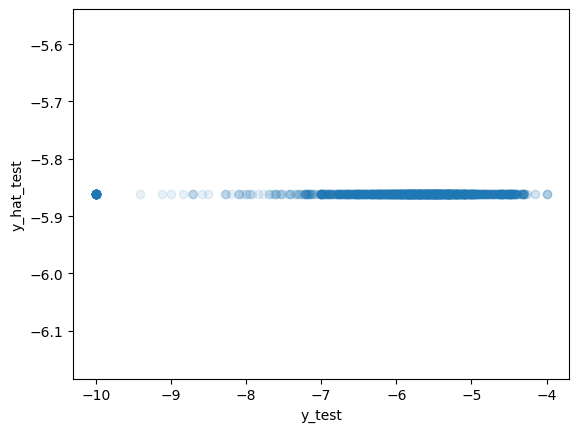

In [37]:
from xgboost import XGBRegressor

is_cv = False
is_save = False
save_path='data/CycPeptMPDB/fps_xgbr.model'

if is_cv:
    from numpy import absolute
    from sklearn.model_selection import RepeatedKFold, cross_val_score

    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
else:
    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    if is_save:
        joblib.dump(model, save_path)
        model = joblib.load(save_path)
    y_hat = model.predict(X_test)
    plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)

### RF regressor

MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.737	1.225	0.000	nan	nan
MAE: 0.737, y mean: -5.876, y_hat mean: -5.863


/home/xiaopeng/Desktop/Pep_pred/env/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/xiaopeng/Desktop/Pep_pred/env/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


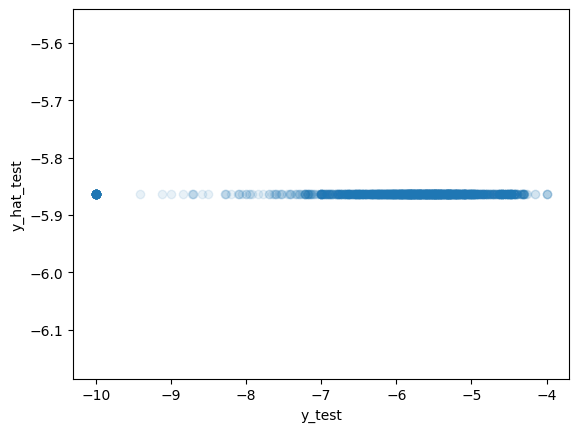

In [38]:
from sklearn.ensemble import RandomForestRegressor
import joblib

is_cv = False
is_save = False
save_path='data/CycPeptMPDB/fps_rf.model'

if is_cv:
    from numpy import absolute
    from sklearn.model_selection import RepeatedKFold, cross_val_score

    model = RandomForestRegressor(max_depth=5, random_state=0)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
else:
    model = RandomForestRegressor(max_depth=5, random_state=0)
    model.fit(X_train, y_train)
    if is_save:
        joblib.dump(model, save_path)
        model = joblib.load(save_path)
    y_hat = model.predict(X_test)
    # model.save_model(save_path)
    plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)